In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import vocab
import torchtext
from torchtext.data.utils import get_tokenizer

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import pandas as pd

import random
import math
import time

from arxiv_title_generation import generate_csv
from arxiv_title_generation import tokenize
from arxiv_title_generation import Encoder, Attention, Decoder, Seq2Seq, init_weights
from arxiv_title_generation import train, evaluate, count_parameters, epoch_time
from arxiv_title_generation import translate_sentence, display_attention

In [3]:
ROOT_PATH = "../../data/raw/title-generation/"

In [6]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
TEXT = Field(tokenize=get_tokenizer("basic_english"),
            init_token = '<sos>', 
            eos_token = '<eos>', 
            include_lengths = True,
            lower = True)

trn_data_fields = [("src", TEXT)]

dataset = data.TabularDataset(
    path=f"{ROOT_PATH}train.csv",
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

In [11]:
train_data, valid_data = dataset.split(split_ratio=0.8)

In [12]:
# python -m gensim.downloader --download glove-wiki-gigaword-300
vec = vocab.Vectors('/home/science/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz')
TEXT.build_vocab(train_data, vectors=vec, min_freq = 2)

In [14]:
len(TEXT.vocab.stoi)

124560

In [17]:
TEXT.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fe19b41ef60>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             '.': 5,
             'of': 6,
             ',': 7,
             'a': 8,
             'and': 9,
             'in': 10,
             'to': 11,
             'we': 12,
             'is': 13,
             'for': 14,
             'that': 15,
             ')': 16,
             '(': 17,
             'with': 18,
             'on': 19,
             'this': 20,
             'are': 21,
             'by': 22,
             'as': 23,
             'an': 24,
             'be': 25,
             'model': 26,
             'which': 27,
             'from': 28,
             'data': 29,
             'can': 30,
             'our': 31,
             'it': 32,
             'at': 33,
             'these': 34,
             'results': 35,
             'models': 36,
             

In [16]:
TEXT.vocab.itos

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'the',
 '.',
 'of',
 ',',
 'a',
 'and',
 'in',
 'to',
 'we',
 'is',
 'for',
 'that',
 ')',
 '(',
 'with',
 'on',
 'this',
 'are',
 'by',
 'as',
 'an',
 'be',
 'model',
 'which',
 'from',
 'data',
 'can',
 'our',
 'it',
 'at',
 'these',
 'results',
 'models',
 "'",
 'show',
 'using',
 'or',
 'paper',
 'method',
 'also',
 'such',
 'have',
 'based',
 'between',
 'two',
 'has',
 'not',
 'time',
 'problem',
 'methods',
 'approach',
 'new',
 'study',
 'proposed',
 'analysis',
 'when',
 'distribution',
 'one',
 'number',
 'algorithm',
 'used',
 'function',
 'its',
 'both',
 's',
 'different',
 'their',
 'where',
 'more',
 'some',
 'network',
 'than',
 'been',
 'system',
 'information',
 'present',
 'under',
 'process',
 'large',
 '$',
 'propose',
 'all',
 'use',
 'learning',
 'random',
 'but',
 'structure',
 'case',
 'theory',
 'other',
 'over',
 'performance',
 'well',
 'each',
 'first',
 'estimation',
 'networks',
 'set',
 'only',
 'parameters',
 'in

In [22]:
def get_batch(source):
    seq_len = len(source) - 1
    data = source[:seq_len]
    target = source[1:1+seq_len].view(-1)
    return data, target

In [24]:
get_batch(torch.tensor([1, 2, 3, 4, 5]))

(tensor([1, 2, 3, 4]), tensor([2, 3, 4, 5]))

In [5]:
class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=512, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i: start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part

In [17]:
print(f"Unique tokens in vocabulary: {len(TEXT.vocab)}")

Unique tokens in vocabulary: 39631


In [19]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [23]:
list(iter(train_iterator))

[
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 231x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]'),
 
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 81x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]'),
 
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 55x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]'),
 
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 237x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]'),
 
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 180x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]'),
 
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 160x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]'),
 
 [torchtext.data.batch.Batch of size 64]
 	[.src]:('[torch.cuda.LongTensor of size 106x64 (GPU 0)]',

In [26]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        # trg, trg_len = batch.trg
        
        src = get_batch(src)
        trg_len = src_len - 1
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            # trg, trg_len = batch.trg
        
            src = get_batch(src)
            trg_len = src_len - 1

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [8]:
# train_batch_it = BatchGenerator(train_iterator, 'src', 'trg')

In [9]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi['<pad>']
SOS_IDX = TEXT.vocab.stoi['<sos>']
EOS_IDX = TEXT.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

In [10]:
model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)
model.apply(init_weights)
glove_vectors = TEXT.vocab.vectors
model.encoder.embedding.weight.data.copy_(glove_vectors)
model.decoder.embedding.weight.data.copy_(glove_vectors)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [11]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 45,001,298 trainable parameters


In [32]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [33]:
MODEL_NAME = 'models/lstm_baseline.pt'
N_EPOCHS = 10
CLIP = 1

train_history = []
valid_history = []

best_valid_loss = float('inf')

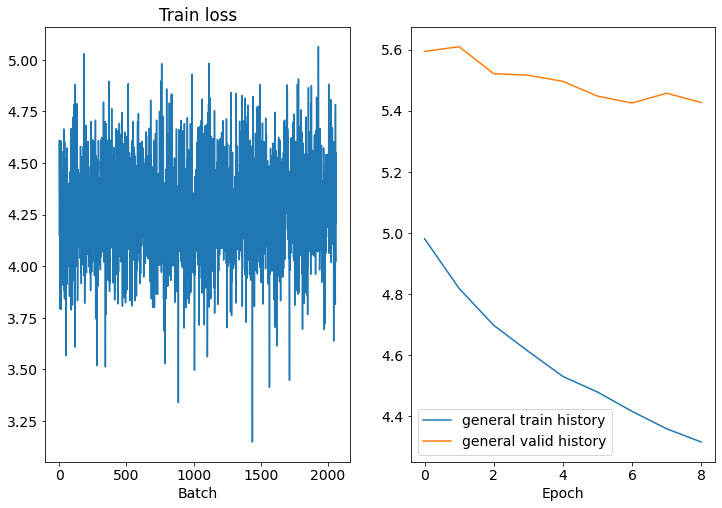

Epoch: 10 | Time: 15m 2s
	Train Loss: 4.276 | Train PPL:  71.917
	 Val. Loss: 5.437 |  Val. PPL: 229.760
CPU times: user 2h 43min 22s, sys: 1h 22min 1s, total: 4h 5min 24s
Wall time: 2h 29min 59s


In [35]:
%%time

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')`

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.initialize_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

#     def init_weights(self):
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

    def initialize_weights(self):
        for param in self.encoder.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
        self.decoder.bias.data.xavier_uniform_()
        self.decoder.weight.data.xavier_uniform_()
                
    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

In [29]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [ ]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [ ]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

In [ ]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')